In [ ]:
# This code needs to exist in every notebook that imports functions from another file so that it will automatically check for changes in that file and update cached versions. 
%load_ext autoreload
%autoreload 2

In [1]:
from process_data import process_all_data

# Get fresh DataFrames
df_main, df_filtered, df_cbf, df_cbf_logical, df_filtered_logical, df_filtered_forCN, df_filtered_forMCI, df_filtered_forRecovery = process_all_data()

Loaded ADNIMERGE_27Jan2025.csv: 16421 rows, 116 columns
Loaded ADNIMERGE_DICT_27Jan2025.csv: 113 rows, 33 columns
Loaded ADNI_PICSLASHS_02_15_22_27Jan2025.csv: 1978 rows, 58 columns
Loaded ADNI_PICSL_ASHS_27Jan2025.csv: 2284 rows, 67 columns
Loaded DESIKANLAB_27Jan2025.csv: 1520 rows, 5 columns
Loaded UCSFSNTVOL_27Jan2025.csv: 1874 rows, 15 columns
About to call add_progression_column
Ran add_progression_column
Excluded Chaotic progression
Converted 'ABETA' to numeric float64
Converted 'TAU' to numeric float64
Converted 'PTAU' to numeric float64
Converted 'ABETA' to numeric float64
Converted 'TAU' to numeric float64
Converted 'PTAU' to numeric float64


In [3]:
# For a more readable format, print as a list
print(list(df_cbf_logical.columns))
print(list(df_filtered_logical.columns))


['RID', 'COLPROT', 'ORIGPROT', 'PTID', 'SITE', 'VISCODE', 'EXAMDATE', 'DX_bl', 'AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT', 'PTMARRY', 'APOE4', 'FDG', 'PIB', 'AV45', 'FBB', 'ABETA', 'TAU', 'PTAU', 'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'RAVLT_perc_forgetting', 'LDELTOTAL', 'DIGITSCOR', 'TRABSCOR', 'FAQ', 'MOCA', 'EcogPtMem', 'EcogPtLang', 'EcogPtVisspat', 'EcogPtPlan', 'EcogPtOrgan', 'EcogPtDivatt', 'EcogPtTotal', 'EcogSPMem', 'EcogSPLang', 'EcogSPVisspat', 'EcogSPPlan', 'EcogSPOrgan', 'EcogSPDivatt', 'EcogSPTotal', 'FLDSTRENG', 'FSVERSION', 'IMAGEUID', 'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV', 'DX', 'mPACCdigit', 'mPACCtrailsB', 'EXAMDATE_bl', 'CDRSB_bl', 'ADAS11_bl', 'ADAS13_bl', 'ADASQ4_bl', 'MMSE_bl', 'RAVLT_immediate_bl', 'RAVLT_learning_bl', 'RAVLT_forgetting_bl', 'RAVLT_perc_forgetting_bl', 'LDELTOTAL_BL', 'DIGITSCOR_bl', 'TRABSCOR_bl', 'FAQ_bl', 'mPACCdigit_bl

In [4]:
def check_dementia_onset_distribution(df):
    """
    Analyze the Dementiaonset column to see how many patients transition to dementia
    """
    if 'Dementiaonset' not in df.columns:
        print("Dementiaonset column not found in the dataframe")
        return
    
    total_patients = df['RID'].nunique()
    
    # Group by patient and check for Dementiaonset
    patient_groups = df.groupby('RID')
    
    patients_with_onset = 0
    onset_details = []
    
    for rid, group in patient_groups:
        onset_values = group['Dementiaonset'].dropna()
        if not onset_values.empty:
            patients_with_onset += 1
            
            # Get the months this patient was diagnosed with MCI
            mci_months = group[group['DX'] == 'MCI']['Months'].tolist()
            
            # Get the dementia onset month
            onset_month = onset_values.iloc[0]
            
            # Check if there are MCI observations prior to dementia onset
            mci_before_onset = [m for m in mci_months if m < onset_month]
            
            onset_details.append({
                'RID': rid,
                'Dementiaonset': onset_month,
                'MCI_Observations': len(mci_months),
                'MCI_Before_Onset': len(mci_before_onset)
            })
    
    print(f"Total patients: {total_patients}")
    print(f"Patients with Dementiaonset: {patients_with_onset} ({patients_with_onset/total_patients:.1%})")
    
    # Show details for some patients with onset
    if onset_details:
        print("\nSample of patients with dementia onset:")
        for i, details in enumerate(onset_details[:10]):
            print(f"{i+1}. Patient {details['RID']}: Onset at month {details['Dementiaonset']}, "
                  f"{details['MCI_Observations']} MCI observations, "
                  f"{details['MCI_Before_Onset']} before onset")
    
    return onset_details

In [8]:
# Select columns to be used for the model, later. df_filtered_logical will be used. 

#RID,Months - part of design
#Model1 - all vars
# Model1_LIST=['AGE_Med','PTGENDER','PTEDUCAT','Gen_PHS','FDG','AV45','ABETA','TAU','PTAU','CDRSB','MMSE','WholeBrain','Hippocampus']
#Model2 - all vars, no blood flow
# Model2_LIST=['AGE_Med','PTGENDER','PTEDUCAT','Gen_PHS','FDG','AV45','ABETA','TAU','PTAU','CDRSB','MMSE']
#Model3 - sparse vars only
# Model13LIST=['AGE_Med','PTGENDER','PTEDUCAT','FDG','AV45','ABETA','TAU','PTAU']

print('df_filtered_forMCI')
print(df_filtered_forMCI['RID'].nunique())
print(df_filtered_forMCI['AGE_Med'].unique())
import numpy as np
print(np.sort(df_filtered_forMCI['Month'].unique()))
print(df_filtered_forMCI['DX'].value_counts())
progression_counts = df_filtered_forMCI.groupby('Progression')['RID'].nunique().sort_values(ascending=False)
print("Number of unique subjects in each progression group:")
print(progression_counts)

# Run this before creating your datasets
onset_details = check_dementia_onset_distribution(df_filtered_forMCI)

# If there are patients with onset, examine a few of them in detail
if onset_details:
    for details in onset_details[:5]:
        patient_data = df_filtered_forMCI[df_filtered_forMCI['RID'] == details['RID']]
        print(f"\nPatient {details['RID']} details:")
        print(f"Dementia onset at month: {details['Dementiaonset']}")
        print(f"DX values by month:")
        dx_by_month = patient_data[['Months', 'DX']].sort_values('Months')
        print(dx_by_month)

df_filtered_forMCI
765
['Younger' 'Older']
[  0   3   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96
 102 108 114 120 126 132 138 144 150 156 162 168 174 180 186 192]
DX
MCI         4559
Dementia    1213
Name: count, dtype: int64
Number of unique subjects in each progression group:
Progression
StableMCI        441
MCItoDementia    324
Name: RID, dtype: int64
Total patients: 765
Patients with Dementiaonset: 324 (42.4%)

Sample of patients with dementia onset:
1. Patient 30: Onset at month 6.0, 1 MCI observations, 1 before onset
2. Patient 41: Onset at month 18.0, 3 MCI observations, 3 before onset
3. Patient 42: Onset at month 12.0, 2 MCI observations, 2 before onset
4. Patient 45: Onset at month 12.0, 2 MCI observations, 2 before onset
5. Patient 50: Onset at month 6.0, 1 MCI observations, 1 before onset
6. Patient 54: Onset at month 12.0, 2 MCI observations, 2 before onset
7. Patient 57: Onset at month 18.0, 3 MCI observations, 3 before onset
8. Patient 77: Onset at mon

In [5]:
#Make sure that the data is balanced
# Check for missing values
def analyze_columns(df,columnlist):
    """
    Analyze the data types and ranges of each column in a pandas DataFrame.
    
    Parameters:
    df (pandas.DataFrame): The DataFrame to analyze
    
    Returns:
    pandas.DataFrame: A summary of column types and ranges
    """
    import pandas as pd
    import numpy as np
    
    results = []
    
    for column in columnlist:
        # Get basic info
        dtype = df[column].dtype
        count = df[column].count()
        missing = df[column].isna().sum()
        missing_pct = (missing / len(df)) * 100
        
        # Get range info based on data type
        if pd.api.types.is_numeric_dtype(dtype):
            min_val = df[column].min() if not df[column].empty else None
            max_val = df[column].max() if not df[column].empty else None
            mean_val = df[column].mean() if not df[column].empty else None
            range_info = f"Min: {min_val}, Max: {max_val}, Mean: {mean_val:.2f}"
            data_type = "Numeric"
        elif pd.api.types.is_datetime64_dtype(dtype):
            min_val = df[column].min() if not df[column].empty else None
            max_val = df[column].max() if not df[column].empty else None
            range_info = f"Earliest: {min_val}, Latest: {max_val}"
            data_type = "DateTime"
        else:
            # Categorical or object type
            unique_vals = df[column].nunique()
            top_vals = df[column].value_counts().head(3).to_dict()
            top_vals_str = ", ".join([f"{k}: {v}" for k, v in top_vals.items()])
            range_info = f"Unique values: {unique_vals}, Top values: {top_vals_str}"
            data_type = "Categorical/String"
        
        results.append({
            "Column": column,
            "Type": data_type,
            "Data Type": dtype,
            "Non-Null Count": count,
            "Missing": f"{missing} ({missing_pct:.2f}%)",
            "Range/Values": range_info
        })
    
    return pd.DataFrame(results)

# Example usage:
columnlist=['AGE_Med','PTGENDER','PTEDUCAT','Gen_PHS','FDG','AV45','ABETA','TAU','PTAU','CDRSB','MMSE','WholeBrain','Hippocampus']
summary = analyze_columns(df_filtered_forMCI,columnlist)
print(summary)

         Column                Type Data Type  Non-Null Count        Missing  \
0       AGE_Med  Categorical/String    object            5772      0 (0.00%)   
1      PTGENDER  Categorical/String    object            5772      0 (0.00%)   
2      PTEDUCAT             Numeric     int64            5772      0 (0.00%)   
3       Gen_PHS             Numeric   float64            4933   839 (14.54%)   
4           FDG             Numeric   float64            1573  4199 (72.75%)   
5          AV45             Numeric   float64            1043  4729 (81.93%)   
6         ABETA             Numeric   float64             989  4783 (82.87%)   
7           TAU             Numeric   float64             990  4782 (82.85%)   
8          PTAU             Numeric   float64             989  4783 (82.87%)   
9         CDRSB             Numeric   float64            4551  1221 (21.15%)   
10         MMSE             Numeric   float64            4575  1197 (20.74%)   
11   WholeBrain             Numeric   fl

In [21]:
#Set up utilities, classes, and functions to prepare for modeling
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

def prepare_mci_dementia_data(df, feature_columns, months_column='Months', 
                              rid_column='RID', dx_column='DX', 
                              onset_column='Dementiaonset', max_seq_len=None):
    """
    Prepare longitudinal MCI data for dementia transition prediction
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The filtered dataset containing MCI patients (df_filtered_forMCI)
    feature_columns : list
        List of feature column names to include (Model1_LIST)
    months_column : str
        Name of column containing months since baseline
    rid_column : str
        Name of column containing patient ID
    dx_column : str
        Name of column containing diagnosis
    onset_column : str
        Name of column containing months of dementia onset (Dementiaonset)
    max_seq_len : int or None
        Maximum sequence length to use (None = use actual maximum)
    
    Returns:
    --------
    dataset : MCIDementiaDataset
        PyTorch Dataset for training the model
    feature_stats : dict
        Statistics for feature normalization
    """
    # Get unique patients
    patient_ids = df[rid_column].unique()
    
    # Calculate max sequence length if not provided
    if max_seq_len is None:
        max_seq_len = df.groupby(rid_column).size().max()
    
    # Identify categorical features. If this changes, change patient code below
    categorical_features = ['AGE_Med','PTGENDER']
    numeric_features = [col for col in feature_columns if col not in categorical_features]
    
    # Compute feature statistics for normalization (using only numeric features)
    feature_stats = {
        'mean': {col: df[col].mean() for col in numeric_features},
        'std': {col: df[col].std() for col in numeric_features}
    }
    
    # Initialize lists to collect data
    X_data = []  # Features
    T_data = []  # Time points
    M_data = []  # Masks for missing data
    Y_data = []  # Transition labels
    H_data = []  # Time-to-event horizons
    L_data = []  # Sequence lengths
    
    for patient_id in patient_ids:
        # Get patient data sorted by month
        patient_df = df[df[rid_column] == patient_id].sort_values(by=months_column)
        
        # Check if patient has at least one observation limited to the current features
        if len(patient_df) == 0:
            continue
            
        # Get transition status and time
        had_transition = not pd.isna(patient_df[onset_column].iloc[0])
        transition_time = patient_df[onset_column].iloc[0] if had_transition else float('inf')
        
        # Get sequence length (number of visits)
        seq_length = min(len(patient_df), max_seq_len)
        
        # Initialize arrays for this patient
        patient_x = np.zeros((max_seq_len, len(feature_columns)))
        patient_t = np.zeros(max_seq_len)
        patient_m = np.ones((max_seq_len, len(feature_columns)))  # 1 means missing
        
        # Fill in data for each visit
        for i, (_, visit) in enumerate(patient_df.iterrows()):
            if i >= max_seq_len:
                break
                
            # Fill time point
            patient_t[i] = visit[months_column]
            
            # Process features
            for j, feature in enumerate(feature_columns):
                if feature in visit and not pd.isna(visit[feature]):
                    # Handle categorical features
                    if feature in categorical_features:
                        # Simple binary encoding for gender (assuming 1 for Male, 0 for Female)
                        if feature == 'PTGENDER':
                            patient_x[i, j] = 1 if visit[feature] == 'Male' else 0
                        elif feature == 'AGE_Med':
                            patient_x[i, j] = 1 if visit[feature] == 'Younger' else 0
                    else:
                        # Normalize numeric features
                        patient_x[i, j] = (visit[feature] - feature_stats['mean'][feature]) / feature_stats['std'][feature]
                    
                    # Mark as not missing
                    patient_m[i, j] = 0
        
        # Create transition labels for different prediction horizons (6, 12, 24 months)
        horizons = [6,12,24,36,60,180]  # Prediction horizons in months
        patient_y = np.zeros((max_seq_len, len(horizons)))
        
        for i in range(seq_length):
            current_time = patient_t[i]
            for h_idx, horizon in enumerate(horizons):
                # Will transition within the horizon?
                if had_transition and (transition_time - current_time) <= horizon:
                    patient_y[i, h_idx] = 1
        
        # Append to data lists
        X_data.append(patient_x)
        T_data.append(patient_t)
        M_data.append(patient_m)
        Y_data.append(patient_y)
        H_data.append(horizons)
        L_data.append(seq_length)
    
    # Create dataset
    dataset = MCIDementiaDataset(
        features=np.array(X_data),
        time_points=np.array(T_data),
        masks=np.array(M_data),
        labels=np.array(Y_data),
        horizons=H_data,
        lengths=np.array(L_data)
    )
    
    return dataset, feature_stats


class MCIDementiaDataset(Dataset):
    """PyTorch Dataset for MCI to Dementia transition prediction"""
    
    def __init__(self, features, time_points, masks, labels, horizons, lengths):
        """
        Initialize dataset
        
        Parameters:
        -----------
        features : numpy.ndarray
            Array of shape [n_patients, max_seq_len, n_features]
        time_points : numpy.ndarray
            Array of shape [n_patients, max_seq_len]
        masks : numpy.ndarray
            Array of shape [n_patients, max_seq_len, n_features], 1 for missing
        labels : numpy.ndarray
            Array of shape [n_patients, max_seq_len, n_horizons]
        horizons : list of list
            List of horizon values for each patient
        lengths : numpy.ndarray
            Array of shape [n_patients] with sequence lengths
        """
        self.features = torch.FloatTensor(features)
        self.time_points = torch.FloatTensor(time_points)
        self.masks = torch.BoolTensor(masks.astype(bool))  # Convert to boolean mask
        self.labels = torch.FloatTensor(labels)
        self.horizons = horizons
        self.lengths = torch.LongTensor(lengths)
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return {
            'features': self.features[idx],
            'time_points': self.time_points[idx],
            'masks': self.masks[idx],
            'labels': self.labels[idx],
            'length': self.lengths[idx]
        }


def create_data_loader(dataset, batch_size=16, shuffle=True):
    """Create a DataLoader with appropriate collation"""
    
    def collate_fn(batch):
        # Sort batch by sequence length (descending) for packed sequence
        batch = sorted(batch, key=lambda x: x['length'], reverse=True)
        
        # Stack tensors
        features = torch.stack([item['features'] for item in batch])
        time_points = torch.stack([item['time_points'] for item in batch])
        masks = torch.stack([item['masks'] for item in batch])
        labels = torch.stack([item['labels'] for item in batch])
        lengths = torch.stack([item['length'] for item in batch])
        
        return {
            'features': features,
            'time_points': time_points,
            'masks': masks,
            'labels': labels,
            'lengths': lengths
        }
    
    return DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=shuffle, 
        collate_fn=collate_fn
    )


class SimpleAttentionSurvival(nn.Module):
    def __init__(self, feature_dim, hidden_dim=32, num_horizons=6, dropout=0.3):
        super().__init__()
        # Feature encoding
        self.feature_encoder = nn.Linear(feature_dim, hidden_dim)
        
        # Simple attention mechanism
        self.attention_query = nn.Parameter(torch.randn(hidden_dim))
        self.dropout = nn.Dropout(dropout)
        
        # Multi-horizon prediction heads
        self.num_horizons = num_horizons
        self.classifiers = nn.ModuleList([
            nn.Linear(hidden_dim, 1) for _ in range(num_horizons)
        ])
        
        # Time encoding (to help model understand temporal aspects)
        self.time_encoder = nn.Linear(1, hidden_dim)
        
    def forward(self, features, time_points, masks, lengths=None, return_attention=False):
        """
        Forward pass for multi-horizon dementia transition prediction
        
        Parameters:
        -----------
        features : torch.Tensor
            Tensor of shape [batch_size, seq_len, feature_dim]
        time_points : torch.Tensor
            Tensor of shape [batch_size, seq_len] with months since baseline
        masks : torch.Tensor
            Boolean tensor of shape [batch_size, seq_len, feature_dim] (True for missing)
        lengths : torch.Tensor or None
            Tensor of shape [batch_size] with sequence lengths
        return_attention : bool
            Whether to return attention weights
            
        Returns:
        --------
        predictions : list of torch.Tensor
            List of tensors of shape [batch_size, seq_len, 1] with transition probabilities
        attention_weights : torch.Tensor (optional)
            Tensor of shape [batch_size, seq_len] with attention weights
        """
        batch_size, seq_len, _ = features.shape
        
        # Create sequence mask based on lengths
        seq_mask = None
        if lengths is not None:
            seq_mask = torch.zeros(batch_size, seq_len, dtype=torch.bool, device=features.device)
            for i, length in enumerate(lengths):
                seq_mask[i, length:] = True
        
        # Apply feature mask (set masked features to zero)
        masked_features = features.clone()
        masked_features[masks] = 0.0
        
        # Encode features
        encoded = torch.tanh(self.feature_encoder(masked_features))
        
        # Encode time information
        time_encoded = torch.tanh(self.time_encoder(time_points.unsqueeze(-1)))
        
        # Combine feature and time information
        combined = encoded + time_encoded
        combined = self.dropout(combined)
        
        # Compute attention scores for each timestep
        attention_scores = torch.matmul(combined, self.attention_query)
        
        # Apply sequence mask if provided
        if seq_mask is not None:
            attention_scores = attention_scores.masked_fill(seq_mask, float('-inf'))
        
        # Softmax to get attention weights
        attention_weights = F.softmax(attention_scores, dim=1)
        
        # Apply attention to get context vector for each timestep
        context_vectors = []
        for t in range(seq_len):
            # For each timestep, attend over all previous timesteps
            if t == 0:
                # For the first timestep, just use its own representation
                context_vectors.append(combined[:, 0])
            else:
                # Create a mask to only attend to previous timesteps (including current)
                t_mask = torch.zeros(batch_size, seq_len, dtype=torch.bool, device=features.device)
                t_mask[:, t+1:] = True  # Mask future timesteps
                
                # If we have sequence mask, combine with temporal mask
                if seq_mask is not None:
                    t_mask = t_mask | seq_mask
                
                # Calculate attention for this timestep
                t_scores = attention_scores.clone()
                t_scores = t_scores.masked_fill(t_mask, float('-inf'))
                t_weights = F.softmax(t_scores, dim=1)
                
                # Weighted sum of previous representations
                t_context = torch.sum(t_weights.unsqueeze(2) * combined, dim=1)
                context_vectors.append(t_context)
        
        # Stack context vectors
        context = torch.stack(context_vectors, dim=1)
        
        # Apply prediction heads for each horizon
        predictions = []
        for classifier in self.classifiers:
            # Get prediction for each horizon
            horizon_pred = torch.sigmoid(classifier(context))
            predictions.append(horizon_pred)
        
        if return_attention:
            return predictions, attention_weights
        else:
            return predictions
        
    def predict_patient(self, features, time_points, masks, horizon_idx=1):
        """
        Make prediction for a single patient (useful for interpretation)
        
        Parameters:
        -----------
        features : torch.Tensor
            Tensor of shape [seq_len, feature_dim]
        time_points : torch.Tensor
            Tensor of shape [seq_len] with months since baseline
        masks : torch.Tensor
            Boolean tensor of shape [seq_len, feature_dim] (True for missing)
        horizon_idx : int
            Index of the horizon to predict (default: 1 = 12 months)
            
        Returns:
        --------
        predictions : torch.Tensor
            Tensor of shape [seq_len, 1] with transition probabilities
        attention_weights : torch.Tensor
            Tensor of shape [seq_len] with attention weights
        """
        # Add batch dimension
        features = features.unsqueeze(0)
        time_points = time_points.unsqueeze(0)
        masks = masks.unsqueeze(0)
        
        # Forward pass
        with torch.no_grad():
            predictions, attention_weights = self.forward(
                features, time_points, masks, return_attention=True
            )
        
        # Return predictions for the specified horizon and attention weights
        return predictions[horizon_idx].squeeze(0), attention_weights.squeeze(0)
    

def train_model(model, train_loader, val_loader, criterion=None, 
               num_epochs=50, learning_rate=0.001, device='cuda'):
    """Train the multi-horizon survival model"""
    
    # Default criterion: binary cross entropy for each horizon
    if criterion is None:
        criterion = nn.BCELoss()
    
    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Move model to device
    model = model.to(device)
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_auc': []
    }
    
    # Training loop
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        
        for batch in train_loader:
            # Get batch data
            features = batch['features'].to(device)
            time_points = batch['time_points'].to(device)
            masks = batch['masks'].to(device)
            labels = batch['labels'].to(device)
            lengths = batch['lengths'].to(device)
            
            # Forward pass
            predictions = model(features, time_points, masks, lengths)
            
            # Compute loss for each horizon
            loss = 0.0
            for h_idx in range(len(predictions)):
                # Get predictions and labels for this horizon
                horizon_pred = predictions[h_idx]
                horizon_labels = labels[:, :, h_idx:h_idx+1]
                
                # Compute loss with masking for padded timesteps
                mask = torch.zeros_like(horizon_pred, dtype=torch.bool)
                for i, length in enumerate(lengths):
                    mask[i, length:] = True
                
                # Apply mask to both predictions and labels
                valid_preds = horizon_pred[~mask]
                valid_labels = horizon_labels[~mask]
                
                if len(valid_preds) > 0:
                    horizon_loss = criterion(valid_preds, valid_labels)
                    loss += horizon_loss
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        all_preds = [[] for _ in range(model.num_horizons)]
        all_labels = [[] for _ in range(model.num_horizons)]
        
        with torch.no_grad():
            for batch in val_loader:
                # Get batch data
                features = batch['features'].to(device)
                time_points = batch['time_points'].to(device)
                masks = batch['masks'].to(device)
                labels = batch['labels'].to(device)
                lengths = batch['lengths'].to(device)
                
                # Forward pass
                predictions = model(features, time_points, masks, lengths)
                
                # Compute loss and collect predictions for each horizon
                for h_idx in range(len(predictions)):
                    # Get predictions and labels for this horizon
                    horizon_pred = predictions[h_idx]
                    horizon_labels = labels[:, :, h_idx:h_idx+1]
                    
                    # Create mask for padded timesteps
                    mask = torch.zeros_like(horizon_pred, dtype=torch.bool)
                    for i, length in enumerate(lengths):
                        mask[i, length:] = True
                    
                    # Apply mask
                    valid_preds = horizon_pred[~mask]
                    valid_labels = horizon_labels[~mask]
                    
                    if len(valid_preds) > 0:
                        # Compute loss
                        horizon_loss = criterion(valid_preds, valid_labels)
                        val_loss += horizon_loss.item()
                        
                        # Collect predictions and labels
                        all_preds[h_idx].extend(valid_preds.cpu().numpy())
                        all_labels[h_idx].extend(valid_labels.cpu().numpy())
        
        # Compute AUC for each horizon
        val_auc = []
        for h_idx in range(model.num_horizons):
            if len(all_labels[h_idx]) > 0 and len(np.unique(all_labels[h_idx])) > 1:
                try:
                    from sklearn.metrics import roc_auc_score
                    auc = roc_auc_score(all_labels[h_idx], all_preds[h_idx])
                    val_auc.append(auc)
                except:
                    val_auc.append(float('nan'))
            else:
                val_auc.append(float('nan'))
        
        # Update history
        history['train_loss'].append(train_loss / len(train_loader))
        history['val_loss'].append(val_loss / len(val_loader))
        history['val_auc'].append(np.nanmean(val_auc))
        
        # Print progress
        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {train_loss/len(train_loader):.4f} | '
              f'Val Loss: {val_loss/len(val_loader):.4f} | '
              f'Val AUC: {np.nanmean(val_auc):.4f}')
        
        # Print AUC for each horizon
        horizon_names = ['6m', '12m', '24m', '36m', '60m', '180m']
        horizon_aucs = ' | '.join([f'{h}: {a:.3f}' for h, a in zip(horizon_names, val_auc)])
        print(f'Horizon AUCs: {horizon_aucs}')
    
    return history


def analyze_feature_importance(model, dataset, feature_names, horizon_idx=1, device='cuda'):
    """
    Analyze feature importance across patients
    
    Parameters:
    -----------
    model : SimpleAttentionSurvival
        Trained model
    dataset : MCIDementiaDataset
        Dataset containing patient data
    feature_names : list
        List of feature names
    horizon_idx : int
        Index of the horizon to analyze (default: 1 = 12 months)
    
    Returns:
    --------
    feature_importance : dict
        Dictionary with feature importance scores
    """
    model.eval()
    model = model.to(device)
    
    # Initialize feature importance scores
    importance_scores = np.zeros(len(feature_names))
    
    # Process each patient
    for idx in range(len(dataset)):
        # Get patient data
        patient = dataset[idx]
        features = patient['features'].to(device)
        time_points = patient['time_points'].to(device)
        masks = patient['masks'].to(device)
        length = patient['length'].item()
        
        # Skip patients with too short sequences
        if length <= 1:
            continue
        
        # Forward pass with attention
        with torch.no_grad():
            _, attention_weights = model(
                features.unsqueeze(0),
                time_points.unsqueeze(0),
                masks.unsqueeze(0),
                return_attention=True
            )
        
        # Extract attention weights for valid sequence
        valid_attention = attention_weights[0, :length].cpu().numpy()
        
        # Average attention over the sequence
        avg_attention = np.mean(valid_attention)
        
        # For each feature, calculate how much removing it changes attention
        for j, feature_name in enumerate(feature_names):
            # Create a modified feature tensor with this feature masked
            modified_features = features.clone()
            modified_masks = masks.clone()
            
            # Mask this feature at all time points
            modified_masks[:, j] = True
            
            # Forward pass with feature masked
            with torch.no_grad():
                _, modified_attention = model(
                    modified_features.unsqueeze(0),
                    time_points.unsqueeze(0),
                    modified_masks.unsqueeze(0),
                    return_attention=True
                )
            
            # Extract modified attention
            valid_modified_attention = modified_attention[0, :length].cpu().numpy()
            avg_modified_attention = np.mean(valid_modified_attention)
            
            # Calculate importance as change in attention
            feature_impact = np.abs(avg_modified_attention - avg_attention)
            importance_scores[j] += feature_impact
    
    # Normalize importance scores
    importance_scores /= len(dataset)
    
    # Create a sorted dictionary of feature importance
    feature_importance = {
        name: score for name, score in 
        sorted(zip(feature_names, importance_scores), key=lambda x: x[1], reverse=True)
    }
    
    return feature_importance

In [47]:
# Structure dataset and prepare data loader for modeling

if __name__ == "__main__":
    
    Model1_LIST=['AGE_Med','PTGENDER','PTEDUCAT','Gen_PHS','AV45','ABETA','TAU','PTAU','CDRSB','MMSE','WholeBrain','Hippocampus']
    Model2_LIST=['AGE_Med','PTGENDER','PTEDUCAT','Gen_PHS','CDRSB','MMSE','WholeBrain','Hippocampus']
    Model3_LIST=['AGE_Med','PTGENDER','PTEDUCAT','AV45','ABETA','TAU','PTAU']
    Model4_LIST=['AGE_Med','PTGENDER','PTEDUCAT','Gen_PHS','WholeBrain','Hippocampus']
    
    # Prepare data1
    dataset, feature_stats = prepare_mci_dementia_data(
        df=df_filtered_forMCI,
        feature_columns=Model1_LIST,
        months_column='Months',
        rid_column='RID',
        dx_column='DX',
        onset_column='Dementiaonset'
    )
    # Prepare data2
    dataset2, feature_stats2 = prepare_mci_dementia_data(
        df=df_filtered_forMCI,
        feature_columns=Model2_LIST,
        months_column='Months',
        rid_column='RID',
        dx_column='DX',
        onset_column='Dementiaonset'
    )
    # Prepare data3
    dataset3, feature_stats3 = prepare_mci_dementia_data(
        df=df_filtered_forMCI,
        feature_columns=Model3_LIST,
        months_column='Months',
        rid_column='RID',
        dx_column='DX',
        onset_column='Dementiaonset'
    )
    
    # Prepare data4
    dataset4, feature_stats4 = prepare_mci_dementia_data(
        df=df_filtered_forMCI,
        feature_columns=Model4_LIST,
        months_column='Months',
        rid_column='RID',
        dx_column='DX',
        onset_column='Dementiaonset'
    )
    # # Create data loaders for training and validation
    # train_loader = create_data_loader(dataset, batch_size=16)
    
    # # To use with the model:
    # for batch in train_loader:
    #     features = batch['features']        # Shape: [batch_size, max_seq_len, n_features]
    #     masks = batch['masks']              # Shape: [batch_size, max_seq_len, n_features]
    #     labels = batch['labels']            # Shape: [batch_size, max_seq_len, n_horizons]
    #     lengths = batch['lengths']          # Shape: [batch_size]
        
    #     # Pass to model
    #     # predictions = model(features, masks, return_attention=False)


In [ ]:
# Run and train model 1 - full model
import torch
import numpy as np
from torch.utils.data import random_split

# Assuming we have the dataset ready
# horizons = [6, 12, 24, 36, 60, 180]  # in months

# Split dataset into train and validation
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = create_data_loader(train_dataset, batch_size=16)
val_loader = create_data_loader(val_dataset, batch_size=16)

# Initialize model
feature_dim = len(Model1_LIST)  # Your feature list
model = SimpleAttentionSurvival(
    feature_dim=feature_dim,
    hidden_dim=32,  # Keep this small given dataset size
    num_horizons=6,  # Matches your horizons list
    dropout=0.4  # Increase dropout for regularization
)

# Train model
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=50,
    learning_rate=0.001,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Analyze feature importance for 12-month horizon prediction
feature_importance_12 = analyze_feature_importance(
    model=model,
    dataset=dataset,
    feature_names=Model1_LIST,
    horizon_idx=1,  # 12 months
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Print sorted feature importance
print("Feature Importance for 12-month Dementia Transition Prediction:")
sorted_importance = sorted(feature_importance_12.items(), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_importance:
    print(f"{feature}: {importance:.4f}")

Epoch 1/50 | Train Loss: 4.1833 | Val Loss: 3.8443 | Val AUC: 0.6428
Horizon AUCs: 6m: 0.591 | 12m: 0.623 | 24m: 0.625 | 36m: 0.720 | 60m: 0.746 | 180m: 0.552
Epoch 2/50 | Train Loss: 3.6907 | Val Loss: 3.5479 | Val AUC: 0.6992
Horizon AUCs: 6m: 0.645 | 12m: 0.667 | 24m: 0.705 | 36m: 0.758 | 60m: 0.769 | 180m: 0.650
Epoch 3/50 | Train Loss: 3.4628 | Val Loss: 3.4136 | Val AUC: 0.7347
Horizon AUCs: 6m: 0.690 | 12m: 0.705 | 24m: 0.745 | 36m: 0.773 | 60m: 0.781 | 180m: 0.714
Epoch 4/50 | Train Loss: 3.2936 | Val Loss: 3.2828 | Val AUC: 0.7561
Horizon AUCs: 6m: 0.716 | 12m: 0.736 | 24m: 0.765 | 36m: 0.785 | 60m: 0.787 | 180m: 0.747
Epoch 5/50 | Train Loss: 3.2651 | Val Loss: 3.2396 | Val AUC: 0.7703
Horizon AUCs: 6m: 0.736 | 12m: 0.755 | 24m: 0.780 | 36m: 0.795 | 60m: 0.791 | 180m: 0.764
Epoch 6/50 | Train Loss: 3.1296 | Val Loss: 3.1258 | Val AUC: 0.7859
Horizon AUCs: 6m: 0.764 | 12m: 0.777 | 24m: 0.796 | 36m: 0.803 | 60m: 0.800 | 180m: 0.775
Epoch 7/50 | Train Loss: 3.0408 | Val Loss: 3.

In [38]:
# Run and train model 2 - full model
import torch
import numpy as np
from torch.utils.data import random_split

# Assuming we have the dataset2 ready
# horizons = [6, 12, 24, 36, 60, 180]  # in months

# Split dataset2 into train and validation
total_size = len(dataset2)
train_size = int(0.8 * total_size)
val_size = total_size - train_size
train_dataset, val_dataset = random_split(dataset2, [train_size, val_size])

# Create data loaders
train_loader = create_data_loader(train_dataset, batch_size=16)
val_loader = create_data_loader(val_dataset, batch_size=16)

# Initialize model
feature_dim = len(Model2_LIST)  # Your feature list
model2 = SimpleAttentionSurvival(
    feature_dim=feature_dim,
    hidden_dim=32,  # Keep this small given dataset size
    num_horizons=6,  # Matches your horizons list
    dropout=0.4  # Increase dropout for regularization
)

# Train model
history = train_model(
    model=model2,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=50,
    learning_rate=0.001,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Analyze feature importance for 12-month horizon prediction
feature_importance_12 = analyze_feature_importance(
    model=model2,
    dataset=dataset2,
    feature_names=Model2_LIST,
    horizon_idx=1,  # 12 months
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Print sorted feature importance
print("Feature Importance for 12-month Dementia Transition Prediction:")
sorted_importance = sorted(feature_importance_12.items(), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_importance:
    print(f"{feature}: {importance:.4f}")

Epoch 1/50 | Train Loss: 3.9976 | Val Loss: 3.7264 | Val AUC: 0.6141
Horizon AUCs: 6m: 0.528 | 12m: 0.611 | 24m: 0.698 | 36m: 0.722 | 60m: 0.734 | 180m: 0.391
Epoch 2/50 | Train Loss: 3.7840 | Val Loss: 3.5829 | Val AUC: 0.6779
Horizon AUCs: 6m: 0.572 | 12m: 0.716 | 24m: 0.724 | 36m: 0.745 | 60m: 0.751 | 180m: 0.559
Epoch 3/50 | Train Loss: 3.6025 | Val Loss: 3.4515 | Val AUC: 0.7220
Horizon AUCs: 6m: 0.612 | 12m: 0.760 | 24m: 0.760 | 36m: 0.766 | 60m: 0.767 | 180m: 0.667
Epoch 4/50 | Train Loss: 3.4829 | Val Loss: 3.3095 | Val AUC: 0.7566
Horizon AUCs: 6m: 0.665 | 12m: 0.798 | 24m: 0.785 | 36m: 0.784 | 60m: 0.777 | 180m: 0.730
Epoch 5/50 | Train Loss: 3.2500 | Val Loss: 3.2047 | Val AUC: 0.7813
Horizon AUCs: 6m: 0.723 | 12m: 0.817 | 24m: 0.803 | 36m: 0.797 | 60m: 0.787 | 180m: 0.760
Epoch 6/50 | Train Loss: 3.1519 | Val Loss: 3.0680 | Val AUC: 0.7991
Horizon AUCs: 6m: 0.768 | 12m: 0.830 | 24m: 0.817 | 36m: 0.808 | 60m: 0.796 | 180m: 0.777
Epoch 7/50 | Train Loss: 3.0961 | Val Loss: 2.

In [42]:
# Run and train model 3 - full model
import torch
import numpy as np
from torch.utils.data import random_split

# Assuming we have the dataset3 ready
# horizons = [6, 12, 24, 36, 60, 180]  # in months

# Split dataset3 into train and validation
total_size = len(dataset3)
train_size = int(0.8 * total_size)
val_size = total_size - train_size
train_dataset, val_dataset = random_split(dataset3, [train_size, val_size])

# Create data loaders
train_loader = create_data_loader(train_dataset, batch_size=16)
val_loader = create_data_loader(val_dataset, batch_size=16)

# Initialize model
feature_dim = len(Model3_LIST)  # Your feature list
model3 = SimpleAttentionSurvival(
    feature_dim=feature_dim,
    hidden_dim=32,  # Keep this small given dataset size
    num_horizons=6,  # Matches your horizons list
    dropout=0.4  # Increase dropout for regularization
)

# Train model
history = train_model(
    model=model3,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=50,
    learning_rate=0.001,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Analyze feature importance for 12-month horizon prediction
feature_importance_12 = analyze_feature_importance(
    model=model3,
    dataset=dataset3,
    feature_names=Model3_LIST,
    horizon_idx=1,  # 12 months
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Print sorted feature importance
print("Feature Importance for 12-month Dementia Transition Prediction:")
sorted_importance = sorted(feature_importance_12.items(), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_importance:
    print(f"{feature}: {importance:.4f}")

Epoch 1/50 | Train Loss: 4.0747 | Val Loss: 3.8619 | Val AUC: 0.5402
Horizon AUCs: 6m: 0.521 | 12m: 0.470 | 24m: 0.578 | 36m: 0.634 | 60m: 0.598 | 180m: 0.439
Epoch 2/50 | Train Loss: 3.9900 | Val Loss: 3.8781 | Val AUC: 0.5577
Horizon AUCs: 6m: 0.521 | 12m: 0.478 | 24m: 0.608 | 36m: 0.655 | 60m: 0.623 | 180m: 0.461
Epoch 3/50 | Train Loss: 3.9654 | Val Loss: 3.7781 | Val AUC: 0.5841
Horizon AUCs: 6m: 0.544 | 12m: 0.499 | 24m: 0.644 | 36m: 0.676 | 60m: 0.653 | 180m: 0.490
Epoch 4/50 | Train Loss: 3.9508 | Val Loss: 3.8061 | Val AUC: 0.6032
Horizon AUCs: 6m: 0.565 | 12m: 0.525 | 24m: 0.663 | 36m: 0.679 | 60m: 0.678 | 180m: 0.510
Epoch 5/50 | Train Loss: 3.8908 | Val Loss: 3.7992 | Val AUC: 0.6269
Horizon AUCs: 6m: 0.601 | 12m: 0.609 | 24m: 0.675 | 36m: 0.673 | 60m: 0.674 | 180m: 0.530
Epoch 6/50 | Train Loss: 3.8195 | Val Loss: 3.7478 | Val AUC: 0.6460
Horizon AUCs: 6m: 0.642 | 12m: 0.651 | 24m: 0.675 | 36m: 0.689 | 60m: 0.663 | 180m: 0.556
Epoch 7/50 | Train Loss: 3.7977 | Val Loss: 3.

In [48]:
# Run and train model 4
import torch
import numpy as np
from torch.utils.data import random_split

# Assuming we have the dataset4 ready
# horizons = [6, 12, 24, 36, 60, 180]  # in months

# Split dataset4 into train and validation
total_size = len(dataset4)
train_size = int(0.8 * total_size)
val_size = total_size - train_size
train_dataset, val_dataset = random_split(dataset4, [train_size, val_size])

# Create data loaders
train_loader = create_data_loader(train_dataset, batch_size=16)
val_loader = create_data_loader(val_dataset, batch_size=16)

# Initialize model
feature_dim = len(Model4_LIST)  # Your feature list
model4 = SimpleAttentionSurvival(
    feature_dim=feature_dim,
    hidden_dim=32,  # Keep this small given dataset size
    num_horizons=6,  # Matches your horizons list
    dropout=0.4  # Increase dropout for regularization
)

# Train model
history = train_model(
    model=model4,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=50,
    learning_rate=0.001,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Analyze feature importance for 12-month horizon prediction
feature_importance_12 = analyze_feature_importance(
    model=model4,
    dataset=dataset4,
    feature_names=Model4_LIST,
    horizon_idx=1,  # 12 months
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Print sorted feature importance
print("Feature Importance for 12-month Dementia Transition Prediction:")
sorted_importance = sorted(feature_importance_12.items(), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_importance:
    print(f"{feature}: {importance:.4f}")

Epoch 1/50 | Train Loss: 4.2500 | Val Loss: 3.9847 | Val AUC: 0.4722
Horizon AUCs: 6m: 0.285 | 12m: 0.500 | 24m: 0.564 | 36m: 0.445 | 60m: 0.453 | 180m: 0.585
Epoch 2/50 | Train Loss: 3.9904 | Val Loss: 3.8368 | Val AUC: 0.5535
Horizon AUCs: 6m: 0.403 | 12m: 0.549 | 24m: 0.654 | 36m: 0.508 | 60m: 0.530 | 180m: 0.676
Epoch 3/50 | Train Loss: 3.8810 | Val Loss: 3.7805 | Val AUC: 0.6361
Horizon AUCs: 6m: 0.602 | 12m: 0.614 | 24m: 0.708 | 36m: 0.564 | 60m: 0.597 | 180m: 0.731
Epoch 4/50 | Train Loss: 3.7694 | Val Loss: 3.6189 | Val AUC: 0.7054
Horizon AUCs: 6m: 0.729 | 12m: 0.682 | 24m: 0.755 | 36m: 0.627 | 60m: 0.674 | 180m: 0.765
Epoch 5/50 | Train Loss: 3.7185 | Val Loss: 3.5376 | Val AUC: 0.7427
Horizon AUCs: 6m: 0.767 | 12m: 0.728 | 24m: 0.778 | 36m: 0.674 | 60m: 0.729 | 180m: 0.780
Epoch 6/50 | Train Loss: 3.6188 | Val Loss: 3.4766 | Val AUC: 0.7586
Horizon AUCs: 6m: 0.776 | 12m: 0.748 | 24m: 0.781 | 36m: 0.712 | 60m: 0.752 | 180m: 0.781
Epoch 7/50 | Train Loss: 3.5484 | Val Loss: 3.

In [49]:
def efficient_feature_importance_analysis(model, dataset, feature_names, device='cuda'):
    """
    Efficiently analyze feature importance across all horizons in a single pass
    
    Parameters:
    -----------
    model : SimpleAttentionSurvival
        Trained model
    dataset : MCIDementiaDataset
        Dataset containing patient data
    feature_names : list
        List of feature names
    device : str
        Device to run the model on
        
    Returns:
    --------
    importance_by_horizon : dict
        Dictionary with feature importance scores for each horizon
    """
    model.eval()
    model = model.to(device)
    
    # Get number of horizons
    num_horizons = model.num_horizons
    
    # Initialize feature importance scores for each horizon
    importance_by_horizon = {h: np.zeros(len(feature_names)) for h in range(num_horizons)}
    
    # Create a data loader with batch size 1 to process patients one by one
    loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
    
    for batch in loader:
        # Get patient data
        features = batch['features'].to(device)
        time_points = batch['time_points'].to(device)
        masks = batch['masks'].to(device)
        
        # Check if 'lengths' is in the batch - if not, create it from the mask
        if 'lengths' in batch:
            lengths = batch['lengths'].to(device)
        else:
            # Infer length from the mask - assume valid data has at least one non-masked feature
            seq_mask = ~masks.all(dim=2)  # True where at least one feature is present
            lengths = seq_mask.sum(dim=1).to(device)  # Count valid timesteps
        
        length = lengths[0].item()
        
        # Skip patients with too short sequences
        if length <= 1:
            continue
        
        # Forward pass with attention to get base prediction
        with torch.no_grad():
            predictions, attention_weights = model(
                features, time_points, masks, lengths, return_attention=True
            )
        
        # Extract attention weights for valid sequence
        valid_attention = attention_weights[0, :length].cpu().numpy()
        avg_attention = np.mean(valid_attention)
        
        # For each feature, calculate importance for all horizons at once
        for j, feature_name in enumerate(feature_names):
            # Create a modified feature tensor with this feature masked
            modified_masks = masks.clone()
            
            # Mask this feature at all time points
            modified_masks[:, :, j] = True
            
            # Forward pass with feature masked
            with torch.no_grad():
                modified_predictions, modified_attention = model(
                    features, time_points, modified_masks, lengths, return_attention=True
                )
            
            # Calculate importance for each horizon separately
            for h in range(num_horizons):
                # Get predictions for this horizon
                original_pred = predictions[h][0, :length].cpu().numpy()
                modified_pred = modified_predictions[h][0, :length].cpu().numpy()
                
                # Calculate mean prediction change when feature is masked
                original_mean = np.mean(original_pred)
                modified_mean = np.mean(modified_pred)
                
                # Feature impact is the absolute change in prediction
                horizon_impact = np.abs(modified_mean - original_mean)
                
                # Update importance for this specific horizon
                importance_by_horizon[h][j] += horizon_impact
    
    # Normalize importance scores
    for h in range(num_horizons):
        importance_by_horizon[h] /= len(dataset)
    
    # Convert to feature-indexed dictionaries
    result = {}
    for h in range(num_horizons):
        result[h] = {
            name: score for name, score in 
            sorted(zip(feature_names, importance_by_horizon[h]), key=lambda x: x[1], reverse=True)
        }
    
    return result


def plot_relative_feature_importance(model, dataset, feature_names, horizons=None, 
                                     top_k=None, figsize=(12, 8), device='cuda'):
    """
    Create a line plot showing relative feature importance (as percentages) 
    across prediction horizons
    
    Parameters similar to fast_plot_feature_importance_over_time
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    
    # Set default horizons if not provided
    if horizons is None:
        horizons = ["6 months", "12 months", "24 months", "36 months", "60 months", "120 months"]
    
    # Calculate feature importance for all horizons efficiently
    importance_by_horizon = efficient_feature_importance_analysis(
        model=model,
        dataset=dataset,
        feature_names=feature_names,
        device=device
    )
    
    # Convert to percentages for each horizon
    percent_importance = {h: {} for h in range(len(horizons))}
    for h in range(len(horizons)):
        # Get total importance for this horizon
        values = list(importance_by_horizon[h].values())
        total = sum(values)
        
        # Convert each feature's importance to percentage
        if total > 0:  # Prevent division by zero
            for feature in feature_names:
                percent_importance[h][feature] = (importance_by_horizon[h][feature] / total) * 100
    
    # Restructure data for plotting
    feature_importance_over_time = {feature: [] for feature in feature_names}
    for h in range(len(horizons)):
        for feature in feature_names:
            feature_importance_over_time[feature].append(percent_importance[h][feature])
    
    # If top_k is specified, filter for top features based on average importance
    if top_k is not None:
        avg_importance = {feature: sum(scores) / len(scores) 
                         for feature, scores in feature_importance_over_time.items()}
        
        top_features = sorted(avg_importance.keys(), 
                             key=lambda x: avg_importance[x], 
                             reverse=True)[:top_k]
        
        feature_importance_over_time = {f: feature_importance_over_time[f] 
                                      for f in top_features}
    
    # Create the plot
    plt.figure(figsize=figsize)
    sns.set_style("whitegrid")
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(feature_importance_over_time)))
    
    for (feature, scores), color in zip(feature_importance_over_time.items(), colors):
        plt.plot(horizons, scores, marker='o', linewidth=2, label=feature, color=color)
    
    # Customize plot
    plt.title('Relative Feature Importance Across Prediction Horizons', fontsize=16)
    plt.xlabel('Prediction Horizon', fontsize=14)
    plt.ylabel('Relative Importance (%)', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.ylim(0, max([max(scores) for scores in feature_importance_over_time.values()]) * 1.1)
    
    # Add legend
    plt.legend(title='Features', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust layout
    plt.tight_layout()
    
    return plt.gcf()

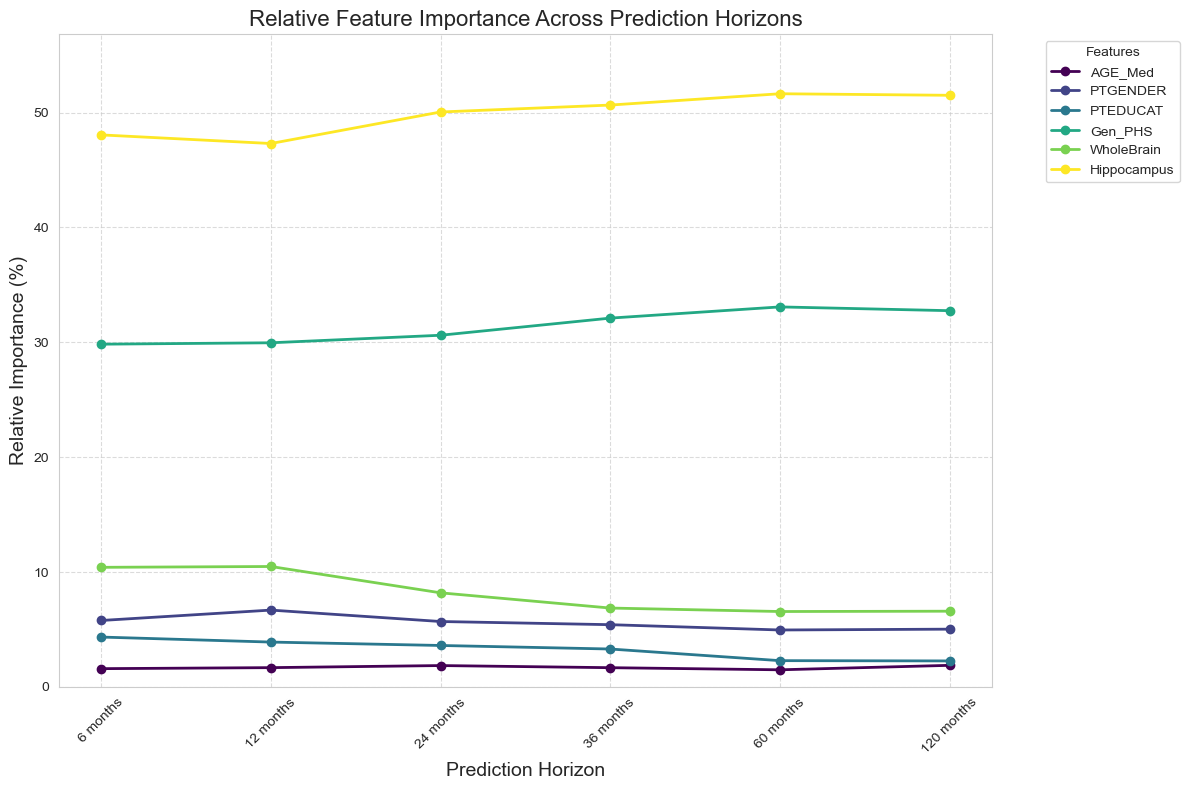

In [50]:
# plot feature importance over time: select variables for right model
import matplotlib.pyplot as plt
import seaborn as sns
horizon_months = [6, 12, 24, 36, 60, 180]
horizon_labels = [f"{m} months" for m in horizon_months]

fig = plot_relative_feature_importance(
    model=model4,
    dataset=dataset4,
    feature_names=Model4_LIST,
    horizons=None,
    top_k=None,  # Show all features
    figsize=(12, 8),
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

plt.savefig('feature_importance_over_time_model4.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Debugging Functions Here # # #
def check_class_distribution(data_loader, horizons=None):
    """
    Check the distribution of transition and non-transition cases in the dataset
    
    Parameters:
    -----------
    data_loader : DataLoader
        PyTorch DataLoader containing the dataset
    horizons : list or None
        List of horizon names (e.g., ["6 months", "12 months", ...])
        If None, will use default horizon names
        
    Returns:
    --------
    distribution : dict
        Dictionary containing transition statistics
    """
    if horizons is None:
        horizons = ["6 months", "12 months", "24 months", "36 months", "60 months", "180 months"]
    
    # Initialize counters
    total_sequences = 0
    total_observations = 0
    total_patients = 0
    
    # For each horizon, track transitions and non-transitions
    horizon_stats = {h: {"transition": 0, "no_transition": 0} for h in horizons}
    
    # Track patients who have at least one transition
    patients_with_transition = set()
    
    # Process each batch
    for batch in data_loader:
        # Get batch data
        labels = batch['labels']         # Shape: [batch_size, seq_len, n_horizons]
        lengths = batch['lengths']       # Shape: [batch_size]
        
        # Count patients
        batch_size = labels.shape[0]
        total_patients += batch_size
        
        # Process each patient
        for i in range(batch_size):
            length = lengths[i].item()
            total_sequences += 1
            total_observations += length
            
            # Patient ID (use batch index as proxy if actual IDs not available)
            patient_id = f"batch_patient_{i}"
            
            # Check transitions for each horizon
            for h_idx, horizon in enumerate(horizons):
                # Get labels for this horizon
                horizon_labels = labels[i, :length, h_idx]
                
                # Count transitions and non-transitions
                transitions = horizon_labels.sum().item()
                
                if transitions > 0:
                    horizon_stats[horizon]["transition"] += transitions
                    patients_with_transition.add(patient_id)
                
                non_transitions = length - transitions
                horizon_stats[horizon]["no_transition"] += non_transitions
    
    # Calculate percentages and prepare results
    distribution = {
        "total_patients": total_patients,
        "total_sequences": total_sequences,
        "total_observations": total_observations,
        "patients_with_transition": len(patients_with_transition),
        "percent_patients_with_transition": (len(patients_with_transition) / total_patients) * 100,
        "horizons": {}
    }
    
    # Calculate statistics for each horizon
    for horizon in horizons:
        transitions = horizon_stats[horizon]["transition"]
        no_transitions = horizon_stats[horizon]["no_transition"]
        total = transitions + no_transitions
        
        distribution["horizons"][horizon] = {
            "transition_count": transitions,
            "no_transition_count": no_transitions,
            "transition_percent": (transitions / total) * 100 if total > 0 else 0,
            "class_ratio": f"1:{no_transitions/transitions:.1f}" if transitions > 0 else "No transitions"
        }
    
    # Print summary
    print(f"Dataset Summary:")
    print(f"  Total patients: {total_patients}")
    print(f"  Patients with transition: {len(patients_with_transition)} ({distribution['percent_patients_with_transition']:.1f}%)")
    print(f"  Total observations: {total_observations}")
    print("\nHorizon breakdown:")
    
    for horizon in horizons:
        stats = distribution["horizons"][horizon]
        print(f"  {horizon}:")
        print(f"    Transitions: {stats['transition_count']} ({stats['transition_percent']:.1f}%)")
        print(f"    No transitions: {stats['no_transition_count']}")
        print(f"    Class ratio (No:Yes): {stats['class_ratio']}")
    
    return distribution

check_class_distribution(train_loader)

Dataset Summary:
  Total patients: 612
  Patients with transition: 16 (2.6%)
  Total observations: 4629

Horizon breakdown:
  6 months:
    Transitions: 1141.0 (24.6%)
    No transitions: 3488.0
    Class ratio (No:Yes): 1:3.1
  12 months:
    Transitions: 1365.0 (29.5%)
    No transitions: 3264.0
    Class ratio (No:Yes): 1:2.4
  24 months:
    Transitions: 1643.0 (35.5%)
    No transitions: 2986.0
    Class ratio (No:Yes): 1:1.8
  36 months:
    Transitions: 1792.0 (38.7%)
    No transitions: 2837.0
    Class ratio (No:Yes): 1:1.6
  60 months:
    Transitions: 1915.0 (41.4%)
    No transitions: 2714.0
    Class ratio (No:Yes): 1:1.4
  180 months:
    Transitions: 1965.0 (42.4%)
    No transitions: 2664.0
    Class ratio (No:Yes): 1:1.4
Feature Importance for 12-month Dementia Transition Prediction:
CDRSB: 0.0400
MMSE: 0.0163
AV45: 0.0147
ABETA: 0.0070
AGE_Med: 0.0069
PTAU: 0.0040
PTGENDER: 0.0032
Gen_PHS: 0.0032
Hippocampus: 0.0029
PTEDUCAT: 0.0027
TAU: 0.0020
WholeBrain: 0.0020
